---
date: '2024-03-29'
description: Tutorial code of how I Visualize Attention Maps and Feature Maps (Salieancy Maps) in PyTorch timm using PyTorch Hooks as timm does not provide attention intermediates
categories:
- Vision Transformer
- Deep Learning
- PyTorch
- Timm
toc: true
output-file: visualizing-vision-transformers-timm.html
title: Visualize Salincy Maps in Timm Models (ViT) using PyTorch Hooks?
---

In [1]:
import torch
import torch.nn as nn

from skimage import io
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
img_path = "/kaggle/input/image-net-visualization/bird_1.png"
model_path = "vit_small_patch16_224.dino"
image_size = 1024

In [3]:
def get_image(im_path, shape=image_size):
    
    
    img = io.imread(im_path)[:,:,:3] ## HXWXC
    H,W,C = img.shape
    org_img = img.copy()
    
    img = A.Normalize()(image=img)["image"] ## HxWxC
    norm_img = img.copy()
    
    img = np.transpose(img,(2,0,1)) ## CxHxW
    img = np.expand_dims(img,0) ## B=1,CxHxW
    
    img = torch.tensor(img)
    img = nn.Upsample((shape,shape),mode='bilinear')(img)
    
    return img, norm_img, org_img

In [4]:
img,norm_img,org_img = get_image(img_path)

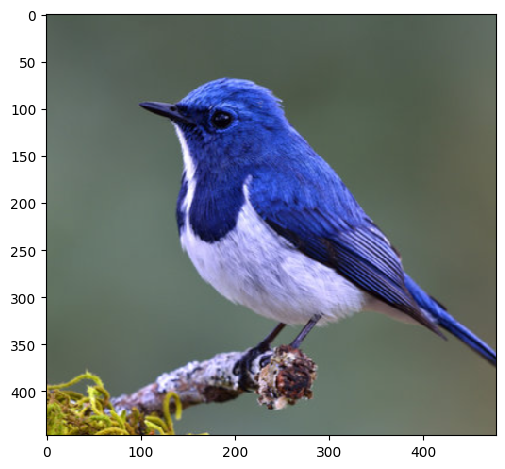

In [5]:
io.imshow(org_img)

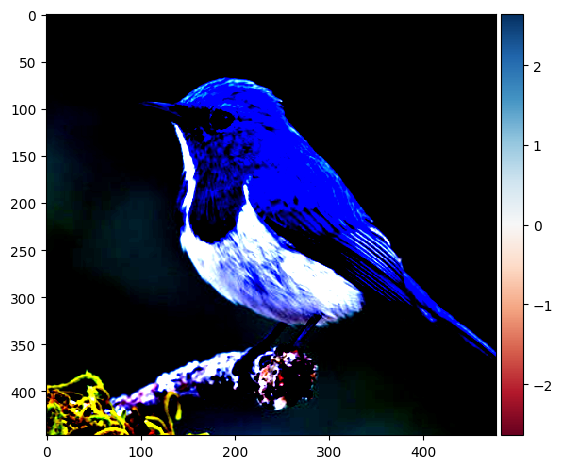

In [6]:
io.imshow(norm_img)

In [7]:
%%capture
! pip install timm

In [8]:
import timm
model = timm.create_model(model_path,pretrained=True,
                         img_size=image_size,
                         dynamic_img_size=True)

model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [9]:
model = model.cuda()

In [10]:
outputs = {}
def get_outputs(name:str):
    def hook(model, input, output):
        outputs[name] = output.detach()
        
    return hook

In [11]:
model.blocks[-1].attn.q_norm.register_forward_hook(get_outputs('Q'))
model.blocks[-1].attn.k_norm.register_forward_hook(get_outputs('K'))
model.blocks[-1].register_forward_hook(get_outputs('features'))

model(img.cuda())

tensor([[-1.6873e+00,  3.3118e+00,  1.6206e-02,  7.5276e+00, -3.8783e+00,
          7.9405e-01, -2.5275e-01, -9.2937e-01, -7.6219e+00,  1.8461e+00,
         -3.7896e+00,  6.9062e+00,  4.9580e+00,  7.0582e+00, -1.4598e+00,
          1.8604e+00,  3.1002e+00, -2.3646e-01,  9.7898e-01,  1.4716e-01,
          4.8010e+00,  9.8696e+00, -6.2256e+00, -4.0314e+00,  4.8572e-01,
          4.6386e+00,  5.2622e+00,  8.2102e+00,  6.6765e+00, -1.0041e+01,
          9.1688e-01,  2.6036e+00,  1.0652e+00, -1.0549e+01, -1.5771e+00,
         -2.4766e+00, -4.6636e+00,  5.6768e+00, -1.7559e+00, -4.9503e-01,
         -2.5628e+00,  1.0277e+01, -4.6592e+00, -3.6269e+00,  6.4073e+00,
         -2.8656e+00, -8.2731e+00,  9.1952e+00, -2.4074e+00, -5.6380e-01,
         -3.4731e+00, -4.7151e+00,  1.8822e-01, -3.8197e+00,  2.5455e+00,
         -1.3325e-01, -4.3335e+00,  7.5765e+00, -3.5712e+00, -4.4365e+00,
          4.9343e-01,  9.1502e-01,  1.0584e+01,  3.9611e+00,  3.8866e+00,
         -4.6030e+00,  1.4714e+00,  4.

In [12]:
scale = model.blocks[-1].attn.scale

In [13]:
outputs["attention"] = (outputs["Q"]@ outputs["K"].transpose(-2, -1))#*scale
# outputs["attention"] = outputs["attention"].softmax(dim=-1)

In [14]:
outputs["attention"].shape

torch.Size([1, 6, 4097, 4097])

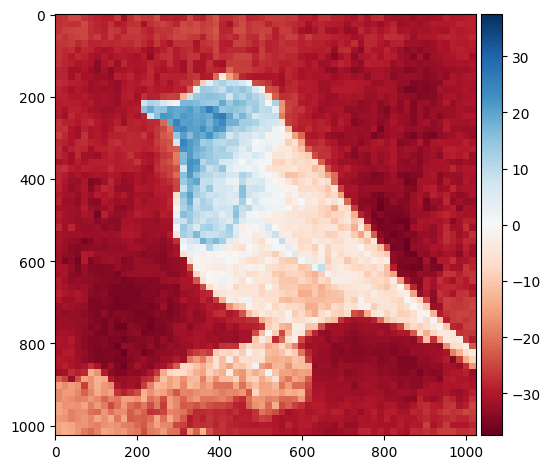

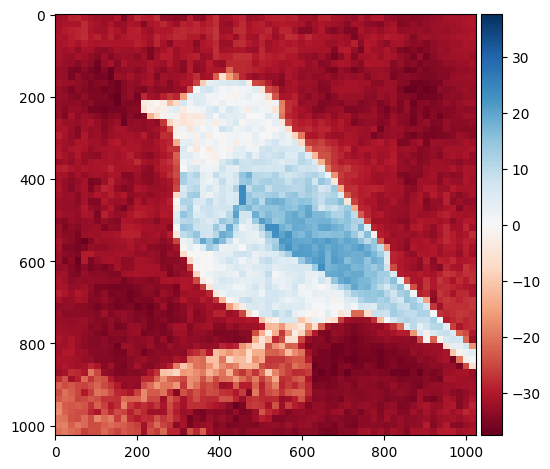

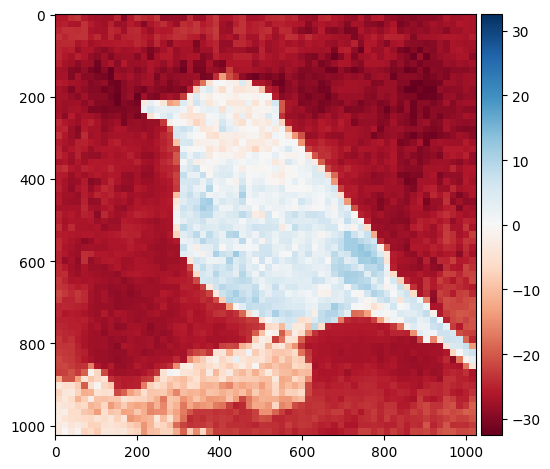

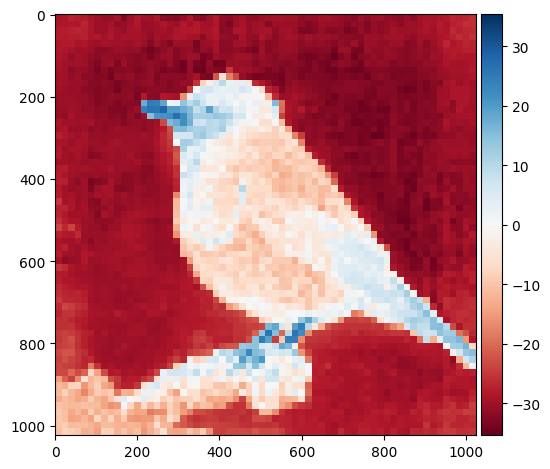

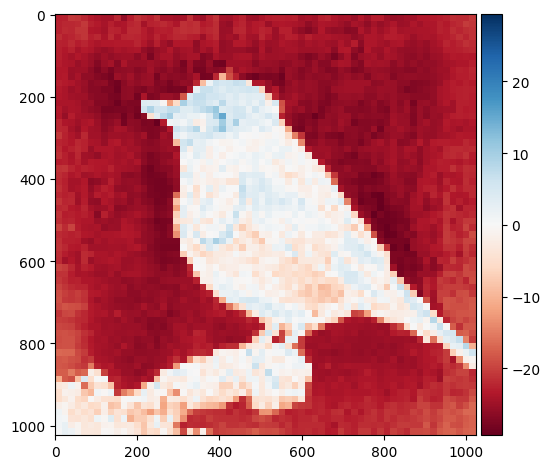

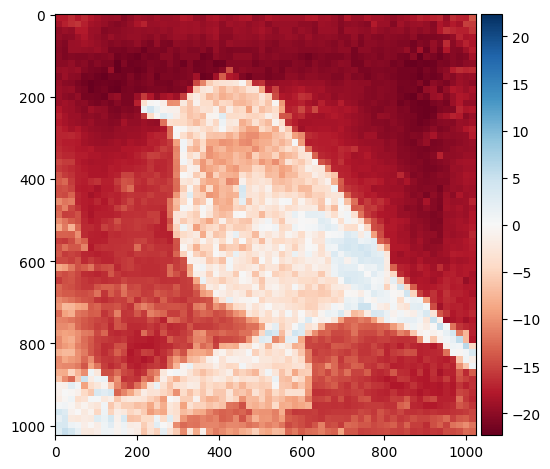

In [15]:
b,num_heads,num_patches_1,num_patches_1 = outputs["attention"].shape
map_size = int(np.sqrt(num_patches_1-1))
for attention_head in range(num_heads):
    attention_map = outputs["attention"][:,attention_head,0,1:] ## 1,4096
    attention_map = attention_map.view(1,1,map_size,map_size)
    
    attention_map = nn.Upsample(size=(image_size,image_size))(attention_map)
    
    attention_map = attention_map[0,0,:,:].detach().cpu().numpy()
    
    io.imshow(attention_map)
    plt.show()

In [16]:
outputs["features"].shape

torch.Size([1, 4097, 384])

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


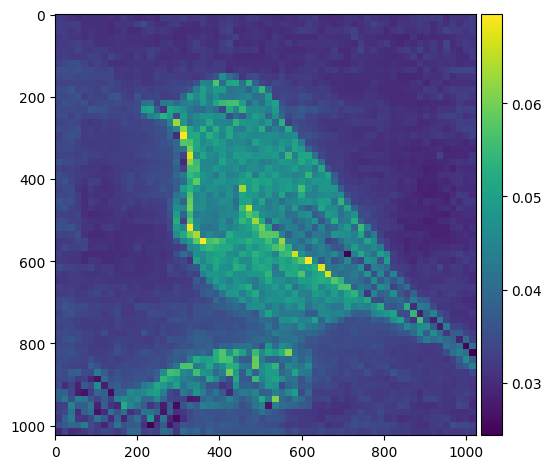

In [17]:
features = outputs["features"].mean(-1)
features = features[:,1:]

features = features.view(1,1,map_size,map_size)

features = nn.Upsample(size=(image_size,image_size))(features)

features = features[0,0,:,:].detach().cpu().numpy()

io.imshow(features)